### 载入数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv('train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('store.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()
test.info()
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ 

In [4]:
print(len(store['Store'].drop_duplicates()))

1115


### 整理数据

In [5]:
#首先整理test数据
#展现Open为nan的数据
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())
test['Date']=pd.to_datetime(test['Date'])

# 把date拆成year，month和day，重新设置DayOfWeek

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)

# print(test["StateHoliday"].value_counts())

test.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [6]:
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,1,3,1,1,0,0,2015,9,17,38
1,2,3,3,1,1,0,0,2015,9,17,38
2,3,7,3,1,1,0,0,2015,9,17,38
3,4,8,3,1,1,0,0,2015,9,17,38
4,5,9,3,1,1,0,0,2015,9,17,38


In [7]:
#接着整理store数据

#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

print(store.query('CompetitionDistance=="NaN"'))
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879
store['CompetitionDistance']=store['CompetitionDistance'].fillna(0)
def f(x):
    return x-int(x)
print(store['CompetitionDistance'].apply(f).value_counts())
# 由于CompetitionDistance所有的小数部分都是0把CompetitionDistance转为int
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))
# 1115-354=761
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceYear']=0
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceMonth']=0

print(min(train['Date']))
print(min(test['Year']))
#训练值里最小的日期是2013-01-01，把没有开业时间的竞争对手店面开店时间随机设置到训练时间之前的随机年份和月份并且改为int型
random.seed(10)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(random.randint(2002,2012))
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(random.randint(1,12))
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

print(store['Promo2'].value_counts())
#571说明没有参与促销的商店是571
print(store['Promo2SinceWeek'].value_counts())
print(store['Promo2SinceYear'].value_counts())
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(0)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

store.info()


     Store  StoreType  Assortment  CompetitionDistance  \
290    291          4           1                  NaN   
621    622          1           3                  NaN   
878    879          4           1                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov  
0.0    1115
Name: CompetitionDistance, dtype: int64
354
1/1/2013
2015
1    571
0    544
Name: Promo2, dtype: int64
14.0    81
40.0    77
31.0    44
10.0    42
5.0     39
37.0    35
1.0     35
45.0    34
13.0    34
22.0    33
18.0    29
35.0    25
9.0     14
27.0    

In [8]:
#处理PromoInterval
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'1,4,7,10','Feb,May,Aug,Nov':'2,5,8,11','Mar,Jun,Sept,Dec':'3,6,9,12'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3,1,1270,9,2008,0,0,0,"0,0,0,0"
1,2,1,1,570,11,2007,1,13,2010,"1,4,7,10"
2,3,1,1,14130,12,2006,1,14,2011,"1,4,7,10"
3,4,3,3,620,9,2009,0,0,0,"0,0,0,0"
4,5,1,1,29910,4,2015,0,0,0,"0,0,0,0"


In [9]:
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1)
store['PromoInterval2']=pd.Series(PromoInterval2)
store['PromoInterval3']=pd.Series(PromoInterval3)
store['PromoInterval4']=pd.Series(PromoInterval4)
        
            
        

In [10]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,PromoInterval1,PromoInterval2,PromoInterval3,PromoInterval4
0,1,3,1,1270,9,2008,0,0,0,"0,0,0,0",0,0,0,0
1,2,1,1,570,11,2007,1,13,2010,"1,4,7,10",1,4,7,10
2,3,1,1,14130,12,2006,1,14,2011,"1,4,7,10",1,4,7,10
3,4,3,3,620,9,2009,0,0,0,"0,0,0,0",0,0,0,0
4,5,1,1,29910,4,2015,0,0,0,"0,0,0,0",0,0,0,0


In [11]:
store=store.melt(
id_vars=['Store','StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval'],   #要保留的主字段
var_name='PromoIntervalTemp',                     #拉长的分类变量
value_name="PromoIntervalMonth"         #拉长的度量值名称
)
print(store.info())
print(store.head())
print(store['PromoIntervalTemp'].value_counts())
store.drop('PromoIntervalTemp',axis=1, inplace=True)
store.drop('PromoInterval',axis=1, inplace=True)
store = store.drop_duplicates()
store['PromoIntervalMonth']=store['PromoIntervalMonth'].astype(int)
print(store.info())
print(store.head())
print(store['PromoIntervalMonth'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 12 columns):
Store                        4460 non-null int64
StoreType                    4460 non-null int32
Assortment                   4460 non-null int32
CompetitionDistance          4460 non-null int32
CompetitionOpenSinceMonth    4460 non-null int32
CompetitionOpenSinceYear     4460 non-null int32
Promo2                       4460 non-null int64
Promo2SinceWeek              4460 non-null int32
Promo2SinceYear              4460 non-null int32
PromoInterval                4460 non-null object
PromoIntervalTemp            4460 non-null object
PromoIntervalMonth           4460 non-null object
dtypes: int32(7), int64(2), object(3)
memory usage: 296.2+ KB
None
   Store  StoreType  Assortment  CompetitionDistance  \
0      1          3           1                 1270   
1      2          1           1                  570   
2      3          1           1                14130   
3      4   

In [12]:
#整理train数据
# print(train.info())
train['Date']=pd.to_datetime(train['Date'])

# 把date拆成year，month和day，重新设置DayOfWeek

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)


print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null int32
SchoolHoliday    1017209 non-null int64
Year             1017209 non-null int64
Month            1017209 non-null int64
Day              1017209 non-null int64
WeekOfYear       1017209 non-null int64
dtypes: int32(1), int64(11)
memory usage: 89.2 MB
None


### 合并数据

In [13]:
train_store=pd.merge(train,store,how='inner',left_on=['Store'],right_on=['Store'])

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries, 0 to 2544742
Data columns (total 21 columns):
Store                        int64
DayOfWeek                    int64
Sales                        int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                 int32
SchoolHoliday                int64
Year                         int64
Month                        int64
Day                          int64
WeekOfYear                   int64
StoreType                    int32
Assortment                   int32
CompetitionDistance          int32
CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2                       int64
Promo2SinceWeek              int32
Promo2SinceYear              int32
PromoIntervalMonth           int32
dtypes: int32(9), int64(12)
memory usage: 339.8 MB


In [14]:
print(len(train_store.query('Promo2==0')[['Store','Year','Month','Day']]))
print(len(train_store.query('Promo2==0')[['Store','Year','Month','Day']].drop_duplicates()))
#给参加促销活动的数据去重
print(len(train_store.query('Promo2==1')[['Store','Year','Month','Day']]))
print(len(train_store.query('Promo2==1')[['Store','Year','Month','Day']].drop_duplicates()))

train_store=train_store.drop_duplicates()
print(len(train_store))

train_store['Promoing']=0

508031
508031
2036712
509178
2544743


In [15]:
#总数1017209
#开始清洗
#标记出正在参与Promo的记录
# train_store.query('Promo2==1 & PromoIntervalMonth==Month & ((Promo2SinceYear==Year & Promo2SinceWeek<=WeekOfYear) | (Promo2SinceYear<Year))')['Promoing']=1
train_store.loc[(train_store['Promo2']==1)&(train_store['PromoIntervalMonth']==train_store['Month'])&(((train_store['Promo2SinceYear']==train_store['Year'])&(train_store['Promo2SinceWeek']<=train_store['WeekOfYear']))|train_store['Promo2SinceYear']<train_store['Year']),'Promoing']=1
train_store['Promoing'].value_counts()

0    2369951
1     174792
Name: Promoing, dtype: int64

In [16]:
#去掉不必要的或者重复的特征
train_store.info()
train_store.drop('PromoIntervalMonth',axis=1, inplace=True)

train_store.drop('Promo2SinceWeek',axis=1, inplace=True)

train_store.drop('Promo2SinceYear',axis=1, inplace=True)

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries, 0 to 2544742
Data columns (total 22 columns):
Store                        int64
DayOfWeek                    int64
Sales                        int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                 int32
SchoolHoliday                int64
Year                         int64
Month                        int64
Day                          int64
WeekOfYear                   int64
StoreType                    int32
Assortment                   int32
CompetitionDistance          int32
CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2                       int64
Promo2SinceWeek              int32
Promo2SinceYear              int32
PromoIntervalMonth           int32
Promoing                     int64
dtypes: int32(9), int64(13)
memory usage: 359.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries,

In [17]:
#总数1017209
train_store=train_store.drop_duplicates()
print(len(train_store))

1192001


In [18]:
temp_train_store=train_store.query('Promoing==1')[['Store','Year','Month','Day','Promoing']]
train_store=train_store.drop('Promoing',axis=1).drop_duplicates()
train_store=pd.merge(train_store,temp_train_store,how='left',on=['Store','Year','Month','Day'])
train_store['Promoing']=train_store['Promoing'].fillna(0)

In [19]:
train_store['Promoing']=train_store['Promoing'].astype(int)
print(train_store.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null int32
SchoolHoliday                1017209 non-null int64
Year                         1017209 non-null int64
Month                        1017209 non-null int64
Day                          1017209 non-null int64
WeekOfYear                   1017209 non-null int64
StoreType                    1017209 non-null int32
Assortment                   1017209 non-null int32
CompetitionDistance          1017209 non-null int32
CompetitionOpenSinceMonth    1017209 non-null int32
CompetitionOpenSinceYear     1017209 non-null int32
Pro

In [20]:
#添加是否有竞争对手信息，然后删除竞争对手开始时间年/月
train_store['IsCompetition']=0
train_store.head()
train_store.loc[(train_store['CompetitionDistance']!=0)&((train_store['CompetitionOpenSinceYear']<train_store['Year'])|(train_store['CompetitionOpenSinceYear']==train_store['Year']&(train_store['CompetitionOpenSinceMonth']<=train_store['Month']))),'IsCompetition']=1

In [21]:
train_store['IsCompetition'].value_counts()


1    900320
0    116889
Name: IsCompetition, dtype: int64

In [22]:
train_store.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                  1017209 non-null int64
DayOfWeek              1017209 non-null int64
Sales                  1017209 non-null int64
Customers              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
StateHoliday           1017209 non-null int32
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
StoreType              1017209 non-null int32
Assortment             1017209 non-null int32
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
dtypes: int32(5), int64(13)
memory usage: 128.1 MB


In [23]:
# 合并test
test_store=pd.merge(test,store,how='inner',left_on=['Store'],right_on=['Store'])
print(test.info())
print(test_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112656 entries, 0 to 112655
Data columns (total 20 columns):
Id                           112656 non-null int64
Store                        112656 non-null int64
DayOfWeek                    112656 non-null int64
Open                         112656 non-null int32
Promo                        112656 non-null int64
StateHoliday                 112656 non-null int32
Sch

In [24]:
test_store=test_store.drop_duplicates()
print(len(test_store))
test_store['Promoing']=0
#开始清洗
#标记出正在参与Promo的记录
# train_store.query('Promo2==1 & PromoIntervalMonth==Month & ((Promo2SinceYear==Year & Promo2SinceWeek<=WeekOfYear) | (Promo2SinceYear<Year))')['Promoing']=1
test_store.loc[(test_store['Promo2']==1)&(test_store['PromoIntervalMonth']==test_store['Month'])&(((test_store['Promo2SinceYear']==test_store['Year'])&(test_store['Promo2SinceWeek']<=test_store['WeekOfYear']))|test_store['Promo2SinceYear']<test_store['Year']),'Promoing']=1
test_store['Promoing'].value_counts()

test_store.drop(['PromoIntervalMonth','Promo2SinceWeek','Promo2SinceYear'],axis=1, inplace=True)

test_store.info()

112656
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112656 entries, 0 to 112655
Data columns (total 18 columns):
Id                           112656 non-null int64
Store                        112656 non-null int64
DayOfWeek                    112656 non-null int64
Open                         112656 non-null int32
Promo                        112656 non-null int64
StateHoliday                 112656 non-null int32
SchoolHoliday                112656 non-null int64
Year                         112656 non-null int64
Month                        112656 non-null int64
Day                          112656 non-null int64
WeekOfYear                   112656 non-null int64
StoreType                    112656 non-null int32
Assortment                   112656 non-null int32
CompetitionDistance          112656 non-null int32
CompetitionOpenSinceMonth    112656 non-null int32
CompetitionOpenSinceYear     112656 non-null int32
Promo2                       112656 non-null int64
Promoing       

In [25]:
test_store=test_store.drop_duplicates()
print(len(test_store))
#41088

46324


In [26]:
temp_test_store=test_store.query('Promoing==1')[['Store','Year','Month','Day','Promoing']]
test_store=test_store.drop('Promoing',axis=1).drop_duplicates()
test_store=pd.merge(test_store,temp_test_store,how='left',on=['Store','Year','Month','Day'])
test_store['Promoing']=test_store['Promoing'].fillna(0)
print(len(test_store))

41088


In [27]:
#添加是否有竞争对手信息，然后删除竞争对手开始时间年/月
test_store['IsCompetition']=0
test_store.head()
test_store.loc[(test_store['CompetitionDistance']!=0)&((test_store['CompetitionOpenSinceYear']<test_store['Year'])|(test_store['CompetitionOpenSinceYear']==test_store['Year']&(test_store['CompetitionOpenSinceMonth']<=test_store['Month']))),'IsCompetition']=1
test_store.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
test_store['Promoing']=test_store['Promoing'].astype(int)
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                     41088 non-null int64
Store                  41088 non-null int64
DayOfWeek              41088 non-null int64
Open                   41088 non-null int32
Promo                  41088 non-null int64
StateHoliday           41088 non-null int32
SchoolHoliday          41088 non-null int64
Year                   41088 non-null int64
Month                  41088 non-null int64
Day                    41088 non-null int64
WeekOfYear             41088 non-null int64
StoreType              41088 non-null int32
Assortment             41088 non-null int32
CompetitionDistance    41088 non-null int32
Promo2                 41088 non-null int64
Promoing               41088 non-null int32
IsCompetition          41088 non-null int64
dtypes: int32(6), int64(11)
memory usage: 4.7 MB


In [28]:
# 显示train_store和test_store
test_store.info()
train_store.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                     41088 non-null int64
Store                  41088 non-null int64
DayOfWeek              41088 non-null int64
Open                   41088 non-null int32
Promo                  41088 non-null int64
StateHoliday           41088 non-null int32
SchoolHoliday          41088 non-null int64
Year                   41088 non-null int64
Month                  41088 non-null int64
Day                    41088 non-null int64
WeekOfYear             41088 non-null int64
StoreType              41088 non-null int32
Assortment             41088 non-null int32
CompetitionDistance    41088 non-null int32
Promo2                 41088 non-null int64
Promoing               41088 non-null int32
IsCompetition          41088 non-null int64
dtypes: int32(6), int64(11)
memory usage: 4.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (

In [36]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [37]:
# 检查测试数据
train_data=train_store.drop('Sales',axis=1)
train_target=train_store['Sales']
X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.4, random_state=0)
dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))
dvalid = xgb.DMatrix(X_test, np.log(y_test + 1))
dtest = xgb.DMatrix(test)

In [38]:
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 12,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 2000
gbm1 = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:6.02994	eval-rmse:6.03007	train-rmspe:0.909878	eval-rmspe:0.909971
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.82507	eval-rmse:4.82522	train-rmspe:0.906354	eval-rmspe:0.906447
[2]	train-rmse:3.86285	eval-rmse:3.86298	train-rmspe:0.897331	eval-rmspe:0.897425
[3]	train-rmse:3.09665	eval-rmse:3.09696	train-rmspe:0.879138	eval-rmspe:0.879236
[4]	train-rmse:2.47898	eval-rmse:2.47924	train-rmspe:0.848769	eval-rmspe:0.848865
[5]	train-rmse:1.9851	eval-rmse:1.98542	train-rmspe:0.804688	eval-rmspe:0.804788
[6]	train-rmse:1.59214	eval-rmse:1.59249	train-rmspe:0.747422	eval-rmspe:0.747535
[7]	train-rmse:1.27613	eval-rmse:1.27652	train-rmspe:0.68101	eval-rmspe:0.681135
[8]	train-rmse:1.0235	eval-rmse:1.02392	train-rmspe:0.608895	eval-rmspe:0.609032
[9]	train-rmse:0.821708	eval-rmse:0.822218	train-rmspe:0.535236	eval-rmspe:0.535403
[10]	train-rmse:0.660963	eval-rmse:

[96]	train-rmse:0.044879	eval-rmse:0.054303	train-rmspe:0.044396	eval-rmspe:0.052861
[97]	train-rmse:0.044785	eval-rmse:0.054229	train-rmspe:0.044301	eval-rmspe:0.052782
[98]	train-rmse:0.044704	eval-rmse:0.0542	train-rmspe:0.044223	eval-rmspe:0.052759
[99]	train-rmse:0.044569	eval-rmse:0.05413	train-rmspe:0.044092	eval-rmspe:0.052689
[100]	train-rmse:0.044473	eval-rmse:0.054104	train-rmspe:0.043996	eval-rmspe:0.052662
[101]	train-rmse:0.044411	eval-rmse:0.054061	train-rmspe:0.043937	eval-rmspe:0.052624
[102]	train-rmse:0.044238	eval-rmse:0.053946	train-rmspe:0.043758	eval-rmspe:0.052501
[103]	train-rmse:0.044061	eval-rmse:0.053881	train-rmspe:0.043579	eval-rmspe:0.052432
[104]	train-rmse:0.043924	eval-rmse:0.053826	train-rmspe:0.043447	eval-rmspe:0.05238
[105]	train-rmse:0.0438	eval-rmse:0.053772	train-rmspe:0.04333	eval-rmspe:0.052325
[106]	train-rmse:0.043721	eval-rmse:0.053758	train-rmspe:0.04325	eval-rmspe:0.052308
[107]	train-rmse:0.043578	eval-rmse:0.053656	train-rmspe:0.043106	

[192]	train-rmse:0.03627	eval-rmse:0.051697	train-rmspe:0.035991	eval-rmspe:0.050257
[193]	train-rmse:0.036211	eval-rmse:0.051697	train-rmspe:0.035934	eval-rmspe:0.050257
[194]	train-rmse:0.03616	eval-rmse:0.051695	train-rmspe:0.035885	eval-rmspe:0.050255
[195]	train-rmse:0.036107	eval-rmse:0.051688	train-rmspe:0.035833	eval-rmspe:0.050248
[196]	train-rmse:0.036047	eval-rmse:0.051682	train-rmspe:0.035779	eval-rmspe:0.05025
[197]	train-rmse:0.036002	eval-rmse:0.051667	train-rmspe:0.035735	eval-rmspe:0.050237
[198]	train-rmse:0.035941	eval-rmse:0.051656	train-rmspe:0.035675	eval-rmspe:0.050227
[199]	train-rmse:0.035891	eval-rmse:0.051651	train-rmspe:0.035625	eval-rmspe:0.050219
[200]	train-rmse:0.035807	eval-rmse:0.051641	train-rmspe:0.035538	eval-rmspe:0.05021
[201]	train-rmse:0.035767	eval-rmse:0.051635	train-rmspe:0.035499	eval-rmspe:0.050205
[202]	train-rmse:0.035714	eval-rmse:0.051633	train-rmspe:0.035445	eval-rmspe:0.050202
[203]	train-rmse:0.035652	eval-rmse:0.051619	train-rmspe:0

[288]	train-rmse:0.030886	eval-rmse:0.051336	train-rmspe:0.030681	eval-rmspe:0.049931
[289]	train-rmse:0.030836	eval-rmse:0.051336	train-rmspe:0.030629	eval-rmspe:0.049929
[290]	train-rmse:0.030781	eval-rmse:0.051333	train-rmspe:0.030574	eval-rmspe:0.049927
[291]	train-rmse:0.030753	eval-rmse:0.051334	train-rmspe:0.030546	eval-rmspe:0.049927
[292]	train-rmse:0.030689	eval-rmse:0.051325	train-rmspe:0.030483	eval-rmspe:0.049918
[293]	train-rmse:0.030633	eval-rmse:0.051325	train-rmspe:0.030427	eval-rmspe:0.049917
[294]	train-rmse:0.030571	eval-rmse:0.051322	train-rmspe:0.030365	eval-rmspe:0.049913
[295]	train-rmse:0.030544	eval-rmse:0.051317	train-rmspe:0.030338	eval-rmspe:0.049908
[296]	train-rmse:0.030483	eval-rmse:0.051319	train-rmspe:0.030279	eval-rmspe:0.04991
[297]	train-rmse:0.030434	eval-rmse:0.051325	train-rmspe:0.030231	eval-rmspe:0.049918
[298]	train-rmse:0.030382	eval-rmse:0.051326	train-rmspe:0.030178	eval-rmspe:0.049919
[299]	train-rmse:0.030297	eval-rmse:0.051327	train-rmsp

[384]	train-rmse:0.026693	eval-rmse:0.051343	train-rmspe:0.026517	eval-rmspe:0.049946
[385]	train-rmse:0.026666	eval-rmse:0.051339	train-rmspe:0.026489	eval-rmspe:0.049942
[386]	train-rmse:0.026644	eval-rmse:0.05134	train-rmspe:0.026467	eval-rmspe:0.049942
[387]	train-rmse:0.026605	eval-rmse:0.051341	train-rmspe:0.026429	eval-rmspe:0.049943
[388]	train-rmse:0.026561	eval-rmse:0.051344	train-rmspe:0.026383	eval-rmspe:0.049945
[389]	train-rmse:0.026526	eval-rmse:0.051342	train-rmspe:0.026349	eval-rmspe:0.049943
[390]	train-rmse:0.026512	eval-rmse:0.051335	train-rmspe:0.026336	eval-rmspe:0.049937
[391]	train-rmse:0.026485	eval-rmse:0.051337	train-rmspe:0.026308	eval-rmspe:0.049938
[392]	train-rmse:0.026445	eval-rmse:0.051338	train-rmspe:0.026269	eval-rmspe:0.04994
[393]	train-rmse:0.026402	eval-rmse:0.051341	train-rmspe:0.026224	eval-rmspe:0.049942
[394]	train-rmse:0.026375	eval-rmse:0.051339	train-rmspe:0.026198	eval-rmspe:0.04994
[395]	train-rmse:0.026357	eval-rmse:0.051344	train-rmspe:

In [29]:
# 切割x和y


# X_train=X_train.as_matrix()
# X_test=X_test.as_matrix()

In [30]:

gbm1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
predictions_test=gbm.predict(X_test)

In [35]:
# def rmspe(y, yhat):
#     return np.sqrt(np.mean((yhat/y-1) ** 2))
# np.log1p(X_valid.Sales)
print(np.expm1(predictions_test))

[ inf  inf  inf ...,  inf  inf  inf]


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in expm1
  after removing the cwd from sys.path.


In [33]:
error = rmspe(y_test.values, np.expm1(predictions_test))
print('RMSPE: {:.6f}'.format(error))

NameError: name 'rmspe' is not defined

In [64]:
print(predictions_test)
error = rmspe(np.exp(predictions_test) - 1, y_test.values)
print('error', error)

[ 3823.72436523  7105.19628906  6492.51904297 ...,  8516.38867188
  6126.64501953  5398.74462891]
error nan


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


In [43]:
# submission = pd.DataFrame({'Id': test['Id'],
#                             'Sales': predictions})
# print(submission)
# submission.to_csv("submission.csv",index=False)


          Id        Sales
0          1   292.636566
1          2   204.852600
2          3   638.279968
3          4   638.279968
4          5   184.572479
5          6   184.572479
6          7   184.572479
7          8   184.572479
8          9   168.790024
9         10   168.790024
10        11   168.790024
11        12   184.572479
12        13   236.286469
13        14   701.281372
14        15   701.281372
15        16   739.727661
16        17   739.727661
17        18  1011.719849
18        19   533.091797
19        20   457.074402
20        21   312.416504
21        22   292.313629
22        23   159.091782
23        24   159.091782
24        25   159.091782
25        26   174.874237
26        27   174.874237
27        28   644.364136
28        29   644.364136
29        30   628.581726
...      ...          ...
41058  41059   817.333374
41059  41060   835.933716
41060  41061   741.516785
41061  41062   721.413879
41062  41063   669.740845
41063  41064   669.740845
41064  41065

### 检查正确率

### 处理数据

In [118]:
#看看有没有open为0但是有销售数据的
new_train.query('Open==0 & Sales>0')
#看看销售数据的情况
new_train["Sales"].describe()
# 看看节假日有哪些
new_train["StateHoliday"].drop_duplicates()
#各个StateHolitday的数据值类型 
new_train["StateHoliday"].value_counts()

NameError: name 'new_train' is not defined

In [11]:
new_train.query('Open==0 & Sales>0')
new_train.query('Open==1 & StateHoliday=="c"')['Date'].value_counts()

12/26/2013    19
12/26/2014    19
12/25/2013    17
12/25/2014    16
Name: Date, dtype: int64

In [12]:
new_train.query('Open==0 & SchoolHoliday=="1"')[['Date','Store']]

new_train.query('Store==1')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,7/31/2015,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,7/30/2015,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,7/29/2015,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,7/28/2015,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,7/27/2015,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
5,1,7,7/26/2015,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
6,1,6,7/25/2015,4364,500,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
7,1,5,7/24/2015,3706,459,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
8,1,4,7/23/2015,3769,503,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
9,1,3,7/22/2015,3464,463,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [13]:
#根据常识我觉得客户数和销售量的关系应该很大
#添加一个月份
t=new_train['Date'].str.split('/')
month=[]

for m in t: 
    month.append(m[0])

new_train['Month']=pd.to_numeric(pd.Series(month))

new_train.info()

new_train['Month'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 non-null f

5     103695
3     103695
1     103694
6     100350
4     100350
7      98115
2      93660
12     63550
10     63550
8      63550
11     61500
9      61500
Name: Month, dtype: int64

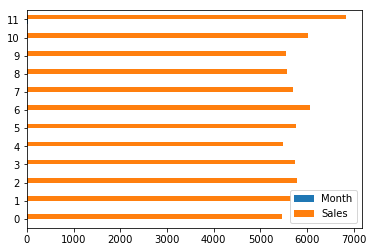

In [46]:
# 按月份sum销售额
new_train[['Month','Sales']].groupby('Month',as_index=False).mean().sort_values('Month')
month_sales=new_train[['Month','Sales']].groupby('Month',as_index=False).mean().sort_values('Month')
month_sales.plot(kind='barh',rot=0)
plt.show()

In [43]:
data_counts=new_train['Date'].value_counts()
print(len(data_counts))
# data_counts.plot(kind='barh',rot=0)
# plt.show()

942


### 单变量分析

TypeError: unhashable type: 'slice'

### 测试xgboost模型

In [15]:
model = XGBClassifier()